In [284]:
# Imports
import numpy as np
from numpy.linalg import norm
from numpy import random
import numpy.ma as ma
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from math import pi, hypot
import pickle
from scipy.optimize import curve_fit

In [285]:
# Implementation of quadtree including self division
class Tree:
    def __init__(self, x, y, w, h, depth=0):
        self.x = x
        self.y = y
        self.pos = np.array([x, y])      # Store coordinates of tree
        self.w = w
        self.h = h
        self.m = 0
        self.depth = depth               # Depth of current node for tree
        self.points = []                 # Contains either 1 or 0 particles per tree
        self.divided = False             # Stores if tree is divided
        
    def divide(self):
        # Division routine to split quadtree
        x, y = self.x, self.y
        w, h = self.w / 2, self.h / 2
        self.nw = Tree(x - w/2, y + h/2, w, h, self.depth + 1)
        self.ne = Tree(x + w/2, y + h/2, w, h, self.depth + 1)
        self.se = Tree(x + w/2, y - h/2, w, h, self.depth + 1)
        self.sw = Tree(x - w/2, y - h/2, w, h, self.depth + 1)
        self.divided = True
    
    def contains(self, x, y):
        # Checks if a given point is within the tree
        west_edge, east_edge = self.x - self.w/2, self.x + self.w/2
        north_edge, south_edge = self.y + self.h/2, self.y - self.h/2
        return (x >= west_edge  and
                x <  east_edge  and
                y <= north_edge and
                y >  south_edge)
    
    def insert(self, x, y, m):
        # Routine to insert point into quadtree
        if not self.contains(x, y):
            return False                            # If point is outside of tree, pass
        self.m += m                                 # Even if this tree is just a parent, add particle mass
        if self.points:                             # If the tree already has a point, divide the tree
            self.divide()
            (self.ne.insert(*self.points) or        # Insert the new point and re-insert the
             self.nw.insert(*self.points) or        # point stored in the parent tree
             self.se.insert(*self.points) or
             self.sw.insert(*self.points))
            self.points = []
        if not self.divided:                        # If the tree is empty and undivided, add point to it
            self.points = [x, y, m]
            return True
        return (self.ne.insert(x, y, m) or          # For any empty, divided trees or ones split above,
                self.nw.insert(x, y, m) or          # insert the given point into one of its children
                self.se.insert(x, y, m) or
                self.sw.insert(x, y, m))
    
    def draw(self, lines, c='k', lw=0.1, **kwargs):
        # Routine to plot the borders of the quadtree
        x1, x2 = self.x - self.w/2, self.x + self.w/2
        y1, y2 = self.y - self.h/2, self.y + self.h/2
        segments = [[(x1, y1), (x2, y1)], [(x1, y2), (x2, y2)], [(x1, y1), (x1, y2)], [(x2, y1), (x2, y2)]]
        for i in segments:
            lines.append(i)
        if self.divided:
            self.nw.draw(lines)
            self.ne.draw(lines)
            self.se.draw(lines)
            self.sw.draw(lines)
    
    def __repr__(self):
        return f'{self.x}, {self.y}'
    
    def __str__(self):
        return f'{self.x}, {self.y}'

In [286]:
random.seed(15)
G = 6.67e-11           # In units of m^3 / kg*s^2
m_S = 5.683e+26        # Saturn mass in kg
pnum = 500             # Number of debris particles to simulate
onum = pnum + 8        # Total simulated objects

In [287]:
def get_dists(nodes, px, py, tree, theta):
    # Returns nodes used in force calculations
    if tree.m == 0:                               # Ignore empty trees
        return
    if tree.points:
        if tree.points[0] == px:                  # No force of particle on itself
            return                              
        nodes.append(tree.points)                 # A tree with a stored point is at lowest level, use point's coordinates
        return
    
    d = hypot(tree.x - px, tree.y - py)
    if tree.w/d < theta:                          # Check if node is far enough away to reduce to tree center of mass
        nodes.append([tree.x, tree.y, tree.m])
        return
    elif tree.divided:                            # If tree is too nearby, repeat search for each of its children
        get_dists(nodes, px, py, tree.ne, theta)
        get_dists(nodes, px, py, tree.nw, theta)
        get_dists(nodes, px, py, tree.sw, theta)
        get_dists(nodes, px, py, tree.se, theta)

In [288]:
def fast_acceleration(tx, ty, tree, theta):
    # Routine to calculate the forces on all objects
    axlist = np.zeros(onum, np.float64)
    aylist = np.zeros(onum, np.float64)
    
    for i in range(onum):
        # Get a list of points to use for calculations using Barnes-Hut implementation
        nodes = []
        get_dists(nodes, tx[i], ty[i], tree, theta)
        nodes = np.array(nodes)
        
        # Separate data from function into positions and mass
        nx = nodes[:,0]
        ny = nodes[:,1]
        nm = nodes[:,2]
        
        # Calculate gravitational acceleration and write to array
        rx = nx - tx[i]
        ry = ny - ty[i]
        r = np.sqrt(np.square(rx) + np.square(ry))
        a = G * nm / np.power(r, 3)
        ax = a * rx
        ay = a * ry
        axlist[i] = np.sum(ax)
        aylist[i] = np.sum(ay)
        
    # We don't want Saturn to move, so manually set to zero
    axlist[0] = 0
    aylist[0] = 0
    return(axlist, aylist)

In [289]:
def plotter(x, y, t):
    # Function to create an image sequence from given timesteps in integration
    plt.axis([x[0]-5e8, x[0]+5e8, y[0]-5e8, y[0]+5e8])
    plt.scatter(x[8:], y[8:], s=10)
    plt.scatter(x[1:7], y[1:7], s=50, color="red")
    plt.scatter(x[0], y[0], s=100, color="orange")
    plt.scatter(x[251], y[251], s=40, color="magenta")
    plt.savefig(fname=f"simpics18/pic{t//1000 + 1}.png")
    plt.clf()

In [290]:
def integrator(tx, ty, tvx, tvy, tm, t, theta):
    #routine to calculate acceleration for all objects     
    dt = 1000
    length = 3*10e3
    while t<length:  
#         plotter(tx, ty, t)
#         print("pic", t//1000, "   ", t)
        
        # Generate a quadtree an insert points for use in force calculations
        qtree = Tree(0.0, 0.0, 8.0e+9, 8.0e+9)
        for i in range(onum):
            qtree.insert(tx[i], ty[i], tm[i])
        
        # Implementation of leapfrog method with forces from Barnes-Hut algorithm
        tx += tvx*dt/2
        ty += tvy*dt/2
        ax, ay = fast_acceleration(tx, ty, qtree, theta)  
        tvx += ax*dt
        tvy += ay*dt
        tx += tvx*dt/2
        ty += tvy*dt/2

        t+=dt
    
    # Optional x position of sample particle for error computations
    return tx[90], ty[90]

In [291]:
def initialize():
    # Function to reset input parameters for multiple simulation runs
    random.seed(15)
    # Initialize Saturn and moons, position along x-axis
    x_init = np.array([1000, 185539000, 237948000, 294619000, 377396000, 527108000, 1221870000, 3560820000], np.float64)
    m = np.array([5.683e+26, 4e+21, 1.1e+20, 6.2e+20, 1.1e+21, 2.3e+21, 1.35e+23, 1.8e+21], np.float64)

    # Initializing and distributing debris particles and moons
    moon_angles = np.append(0, random.uniform(0, 2*pi, size=(7)))
    x = x_init * np.cos(moon_angles)
    y = x_init * np.sin(moon_angles)

    moon_v = np.sqrt(G * m_S / x_init[1:])
    moon_v = np.append(0, moon_v)
    vx = -1 * moon_v * np.sin(moon_angles)
    vy = moon_v * np.cos(moon_angles)

    p_init = random.uniform(67300000, 140300000, size=(pnum))
    p_angles = random.uniform(0, 2*pi, size=(pnum)) 
    px = p_init * np.cos(p_angles)
    py = p_init * np.sin(p_angles)
    pv = np.sqrt(G * m_S / p_init)
    pvx = -1 * pv * np.sin(p_angles)
    pvy = pv * np.cos(p_angles)
    pm = random.uniform(1e20, 2e20, size=(pnum))

    x = np.concatenate((x, px))
    y = np.concatenate((y, py))
    vx = np.concatenate((vx, pvx))
    vy = np.concatenate((vy, pvy))
    nm = np.concatenate((m, pm))
    return x, y, vx, vy, nm

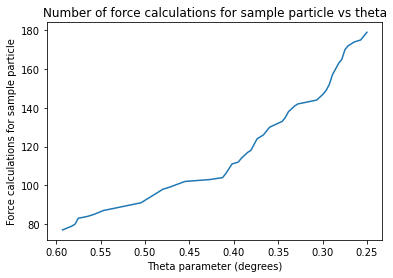

In [292]:
# Get fresh input parameters
nums = []
pnums = []
px, py, pvx, pvy, pm = initialize()

# Generate and fill the tree
qtree = Tree(0.0, 0.0, 8.0e+9, 8.0e+9)
for i in range(len(pm)):
    qtree.insert(px[i], py[i], pm[i])

# Plot the number of nodes for a given theta value for sample particle, ignore repeats
theta = np.linspace(0.25, 0.6, num=100)
for i in theta:
    nodes = []
    get_dists(nodes, px[10], py[10], qtree, i)
    if (len(nodes)) not in pnums:
        pnums.append(len(nodes))
        nums.append([len(nodes), i])
    
nums = np.array(nums)
theta = nums[:,1]
forces = nums[:,0]

# Plot the results, showing number of force calculation points for differing theta
graph, plot1 = plt.subplots()
plot1.plot(theta, forces)
plt.title("Number of force calculations for sample particle vs theta")
plt.xlabel("Theta parameter (degrees)")
plt.ylabel("Force calculations for sample particle")
plot1.invert_xaxis()
# plt.savefig("theta-points-1.png")

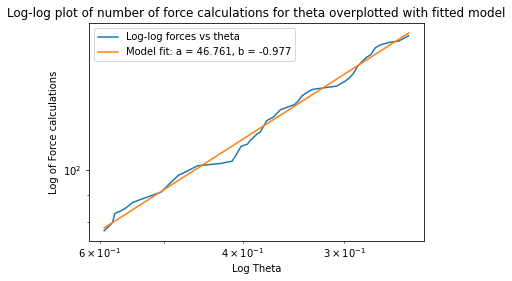

In [293]:
# Log-log plot of the data
graph, plot1 = plt.subplots()
plot1.loglog(theta, forces, label="Log-log forces vs theta")

# Straight lines on a log plot are exponential functions, so define one with parameters
def exp(x, a, b):
    return a * np.power(x, b)

# Fit parameters using scipy optimize_curvefit
popt, pcov = curve_fit(exp, theta, forces)
plt.plot(theta, exp(theta, *popt), label=f"Model fit: a = {round(popt[0], 3)}, b = {round(popt[1], 3)}")

# Overplot fitted model to original data
plt.title("Log-log plot of number of force calculations for theta overplotted with fitted model")
plt.xlabel("Log Theta")
plt.ylabel("Log of Force calculations")
plot1.invert_xaxis()
plt.legend()
# plt.savefig("theta-model-log.png")

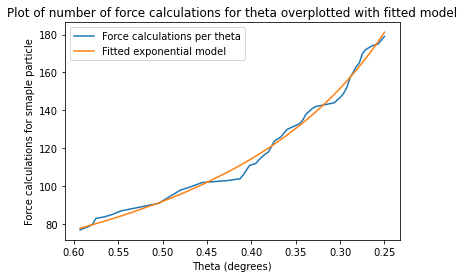

In [294]:
# Same computations as above but in regular plot instead of log-log
graph, plot1 = plt.subplots()
plot1.plot(theta, forces, label="Force calculations per theta")
plot1.plot(theta, exp(theta, *popt), label="Fitted exponential model")
plot1.invert_xaxis()

plt.title("Plot of number of force calculations for theta overplotted with fitted model")
plt.xlabel("Theta (degrees)")
plt.ylabel("Force calculations for smaple particle")
plt.legend()
# plt.savefig("theta-model.png")

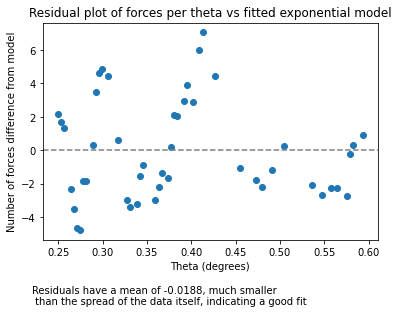

In [295]:
# Determine residuals and plot to verify goodness of fit
residuals = exp(theta, *popt) - forces
plt.scatter(theta, residuals)
plt.axhline(0, c="grey", ls="--")

plt.title("Residual plot of forces per theta vs fitted exponential model")
plt.xlabel("Theta (degrees)")
plt.ylabel("Number of forces difference from model")

plt.figtext(0.1, -0.1, f"Residuals have a mean of {round(np.mean(residuals), 4)}, much smaller \n than the spread of the data itself, indicating a good fit")
plt.savefig("residual-plot.png")

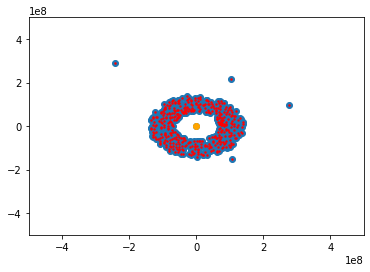

In [296]:
# Visual aid to show points used for force calculation

# Input paramters
px, py, pvx, pvy, pm = initialize()

# Create and fill tree
qtree = Tree(0.0, 0.0, 8.0e+9, 8.0e+9)
for i in range(len(pm)):
    qtree.insert(px[i], py[i], pm[i])

# Fancy plotting to show system and points for force calculations
plt.axis([px[0]-5e8, px[0]+5e8, py[0]-5e8, py[0]+5e8])
plt.scatter(px, py)
nodes = []
get_dists(nodes, px[0], py[0], qtree, 0.1)
nodes = np.array(nodes)
plt.scatter(px[0], py[0], color="orange")
plt.scatter(nodes[:,0], nodes[:,1], s=2, color="red")

In [298]:
# Runs numerical integration over a short time-step for different values of theta, storing in an array
testx, testy = np.zeros(len(theta)), np.zeros(len(theta))
for i in range(len(theta)):
    t = 0
    testx[i], testy[i] = integrator(*initialize(), t, theta[i])  

Text(27.0, 0.5, 'Percent error from theta=0 (absolute value)')

<Figure size 1440x720 with 0 Axes>

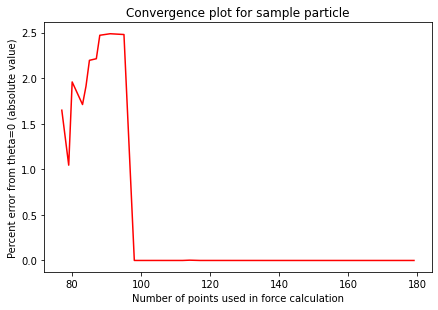

In [299]:
# Calculate distance of the particle from origin with theta=0 and compare to various theta to find convergence

# Theta = 0 calculation, reduces to brute-force routine
baselinex, baseliney = integrator(*initialize(), t, 0)
baselinedist = hypot(baselinex, baseliney)

# Calculate distances per theta and errors from value above
dists = np.sqrt(np.square(testx) + np.square(testy))
err = (dists-baselinedist)/baselinedist
abserr = abs(err)

# Plot the results to visually determine the rate of convergence
plt.figure(figsize=(20, 10))
fig, ax1 = plt.subplots()
ax1.plot(forces, abserr, color='red')

fig.tight_layout()
plt.title("Convergence plot for sample particle")
plt.xlabel("Number of points used in force calculation")
plt.ylabel("Percent error from theta=0 (absolute value)")

# plt.savefig("convergence-plot-5.png")